In [2]:
import pickle
import sys
import os
import datetime

import sklearn
import pandas as pd
import numpy as np
from sklearn.cross_validation import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn import tree
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

In [3]:
#Import data from the processing of data in the journal_training_word2vec notebook
df = pickle.load(open('/mnt/mypartition/pubmed_nlp_research/C_article_replication_and_translational_classification/pickled_objects/dfJournals_trans_categories.p', 'rb'))

In [4]:
print df.shape
print df.columns.values
print df['sentiment'].unique()

(97049, 5)
['sentiment' 'title' 'abstract' 'qualifier_terms' 'descriptor_terms']
['T0' 'T1/T2' 'T3/T4']


In [5]:
#for the journals VM dataframe, change the label of the 'sentiment' column to 'label'
df.columns = ['label', 'title', 'abstract', 'qualifier_terms', 'descriptor_terms']

In [6]:
df[0:10]

,label,title,abstract,qualifier_terms,descriptor_terms
0,T0,Quantification of the relative contributions o...,Amyotrophic lateral sclerosis (ALS) and fronto...,,
1,T0,Ubiquitin Specific Protease 36 (USP36) control...,Ubiquitination of the TrkA neurotrophin recept...,,
2,T0,Functional Diversity of Cytotoxic tRNase/immun...,Contact-dependent growth inhibition (CDI) is a...,,
3,T0,Identification of a distinct substrate binding...,The type III secretion system (T3SS) effector ...,,
4,T0,Role of chondroitin sulfate (CS) modification ...,Protein tyrosine phosphatase receptor type Z (...,,
5,T0,Chemically programmed bispecific antibodies in...,Chemically programmed bispecific antibodies (b...,,
6,T0,Non-mutagenic Suppression of Enterocyte Ferrop...,Iron transfer across the basolateral membrane ...,,
7,T0,Structural plasticity of cholesteryl ester tra...,Cholesteryl ester transfer protein (CETP) medi...,,
8,T0,Identification of a Membrane-Bound Prepore Spe...,Pore-forming toxins (PFT) are cytolytic protei...,,
9,T0,EspR-dependent ESAT-6 secretion of Mycobacteri...,Attenuation of M. bovis BCG strain is related ...,,


In [7]:
df['boolean_label'] = 1
for row in df.iterrows():
    if row[1]['label'] != 'T0':
        df.set_value(row[0], 'boolean_label', 0)

In [9]:
df[0:10]

,label,title,abstract,qualifier_terms,descriptor_terms,boolean_label
0,T0,Quantification of the relative contributions o...,Amyotrophic lateral sclerosis (ALS) and fronto...,,,1
1,T0,Ubiquitin Specific Protease 36 (USP36) control...,Ubiquitination of the TrkA neurotrophin recept...,,,1
2,T0,Functional Diversity of Cytotoxic tRNase/immun...,Contact-dependent growth inhibition (CDI) is a...,,,1
3,T0,Identification of a distinct substrate binding...,The type III secretion system (T3SS) effector ...,,,1
4,T0,Role of chondroitin sulfate (CS) modification ...,Protein tyrosine phosphatase receptor type Z (...,,,1
5,T0,Chemically programmed bispecific antibodies in...,Chemically programmed bispecific antibodies (b...,,,1
6,T0,Non-mutagenic Suppression of Enterocyte Ferrop...,Iron transfer across the basolateral membrane ...,,,1
7,T0,Structural plasticity of cholesteryl ester tra...,Cholesteryl ester transfer protein (CETP) medi...,,,1
8,T0,Identification of a Membrane-Bound Prepore Spe...,Pore-forming toxins (PFT) are cytolytic protei...,,,1
9,T0,EspR-dependent ESAT-6 secretion of Mycobacteri...,Attenuation of M. bovis BCG strain is related ...,,,1


In [12]:
a = datetime.datetime.now().replace(microsecond=0)

y = df['label'].values
skf = StratifiedKFold(y, n_folds=5, shuffle=True)

#include mesh terms in bag of words?
mesh_terms = False
#remove stopwords?
stops = True
#if we want to set max features or not for the BOWs
maxF = 5000
#if want to stem
stem = True

j = 1
avgT0 = []
avgT1T2 = []
avgT3T4 = []
for train_index, test_index in skf:
    #get first test/train split and use
    if j == 1:

        print("ROUND", j)
        j = j + 1
        #use the indexes to subset the df pandas dataframe
        train1, test1 = df.iloc[train_index], df.iloc[test_index]

        print "Cleaning and parsing the training set abstracts...\n"
        # Initialize an empty list to hold the clean reviews
        clean_train_reviews = []

        # Loop over each review; create an index i that goes from 0 to the length
        # of the pandas df column
        for i in range(train1["abstract"].size):
            # Call our function for each one, and add the result to the list of
            # clean reviews
            words = KaggleWord2VecUtility.review_to_words( train1["abstract"].iloc[i], remove_stopwords=stops, stemmer=stem)
            words = words + ' ' + KaggleWord2VecUtility.review_to_words( train1["title"].iloc[i], remove_stopwords=stops, stemmer=stem)
            if mesh_terms:
                words = words + ' ' + KaggleWord2VecUtility.review_to_words( train1["descriptor_terms"].iloc[i], remove_stopwords=stops, stemmer=stem)
                words = words + ' ' + KaggleWord2VecUtility.review_to_words( train1["qualifier_terms"].iloc[i], remove_stopwords=stops, stemmer=stem)
            clean_train_reviews.append(words)

        print len(clean_train_reviews)

        #with tfidf word weighting
        #uses L2 norm by default
        print "Creating the bag of words...\n"

        # Initialize the "TfidfVectorizer" object, which is scikit-learn's
        # bag of words tool.  
        vectorizer = TfidfVectorizer(analyzer = "word",   \
                                 tokenizer = None,    \
                                 preprocessor = None, \
                                #already removed stopwords when preprocessing reviews into words
                                 stop_words = None,
                                max_features = maxF)

        # fit_transform() does two functions: First, it fits the model
        # and learns the vocabulary; second, it transforms our training data
        # into feature vectors. The input to fit_transform should be a list of 
        # strings.
        train_data_features = vectorizer.fit_transform(clean_train_reviews)
        print len(vectorizer.get_feature_names())

        # Numpy arrays are easy to work with, so convert the result to an 
        # array
        train_data_features = train_data_features.toarray()
        print train_data_features.shape

        #Moving on to test set...
        # Create an empty list and append the clean reviews one by one
        clean_test_reviews = [] 

        print "Cleaning and parsing the test set abstracts...\n"
        for i in range(test1["abstract"].size):    
            words = KaggleWord2VecUtility.review_to_words( test1["abstract"].iloc[i], remove_stopwords=stops, stemmer=stem)
            words = words + ' ' + KaggleWord2VecUtility.review_to_words( test1["title"].iloc[i], remove_stopwords=stops, stemmer=stem)
            if mesh_terms:
                words = words + ' ' + KaggleWord2VecUtility.review_to_words( test1["descriptor_terms"].iloc[i], remove_stopwords=stops, stemmer=stem)
                words = words + ' ' + KaggleWord2VecUtility.review_to_words( test1["qualifier_terms"].iloc[i], remove_stopwords=stops, stemmer=stem)
            clean_test_reviews.append(words)

        print "Adding tfidf weights and converting to Bag of Words..."
        # Get a bag of words for the test set, and convert to a numpy array
        test_data_features = vectorizer.transform(clean_test_reviews)
        test_data_features = test_data_features.toarray()

b = datetime.datetime.now().replace(microsecond=0)
print(b-a)

('ROUND', 1)
Cleaning and parsing the training set abstracts...



/home/nlp-vm/anaconda2/lib/python2.7/site-packages/bs4/__init__.py:166: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

To get rid of this warning, change this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


77637
Creating the bag of words...

5000
(77637, 5000)
Cleaning and parsing the test set abstracts...

Adding tfidf weights and converting to Bag of Words...
0:04:51


In [ ]:
print len(train1.loc[train1['boolean_label']==0])/len(df.loc[df['boolean_label']==0])

In [32]:
print "Using the decision tree to make sentiment label predictions..."
forest = tree.DecisionTreeClassifier(min_samples_leaf=1000)
forest = forest.fit( train_data_features, train1['boolean_label'] )
result = forest.predict(test_data_features)

print "Scoring the test set"

# Compute ROC curve and ROC area for each class
# fpr = dict()
# tpr = dict()
# roc_auc = dict()
# for i in range(n_classes):
#     fpr[i], tpr[i], _ = roc_curve(x_test[:, i], result[:, i])
#     roc_auc[i] = auc(fpr[i], tpr[i])

# print roc_auc

print roc_auc_score(test1['boolean_label'], result)

Using the decision tree to make sentiment label predictions...
Scoring the test set
0.904154042133


In [390]:
# from sklearn import tree
# forest = tree.DecisionTreeClassifier(min_samples_leaf=1000)
# forest = forest.fit( train_data_features, train1['boolean_label'] )

# feats = forest.feature_importances_

with open('./original/treeNoStopsNoMeshStemmed.dot', 'w') as dotfile:
    tree.export_graphviz(
        forest,
        dotfile,
        feature_names=vectorizer.get_feature_names(),
        class_names=['T0','not T0']
        )

In [76]:
print train_data_features[::,3311]

[ 0.         0.         0.        ...,  0.         0.0113479  0.       ]


## Testing words as features one by one

In [26]:
# Get value for patients as only feature
names=vectorizer.get_feature_names()
names = np.array([x.encode('UTF8') for x in names])
column_inx = np.where(names == 'patients')[0]
print column_inx

features_patients_train = train_data_features[::,column_inx]
print features_patients_train.shape
features_patients_test = test_data_features[::,column_inx]
print features_patients_test.shape

[]
(77637, 0)
(19412, 0)


In [34]:
names=vectorizer.get_feature_names()
names = np.array([x.encode('UTF8') for x in names])

print np.where(names == 'patient')[0][0]
print np.where(names == 'proof')[0][0]

#column_inx must be in format [1,9] (a list)
column_inx = []
column_inx.append(np.where(names == 'patient')[0][0])
#column_inx.append(np.where(names == 'proof')[0][0])
#column_inx.append(np.where(names == 'protein')[0][0])
#column_inx.append(np.where(names == 'concept')[0][0])
#column_inx.append(np.where(names == 'cell')[0][0])
#column_inx.append(np.where(names == 'compar')[0][0])
#column_inx.append(np.where(names == 'express')[0][0])

features_patients_train = train_data_features[::,column_inx]
print features_patients_train.shape
features_patients_test = test_data_features[::,column_inx]
print features_patients_test.shape
print features_patients_train

3312
3622
(77637, 1)
(19412, 1)
[[ 0.        ]
 [ 0.        ]
 [ 0.        ]
 ..., 
 [ 0.08263653]
 [ 0.        ]
 [ 0.01006316]]


In [61]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(features_patients_train, train1['boolean_label'])

GaussianNB()

In [62]:
result = model.predict(features_patients_train)
print roc_auc_score(train1['boolean_label'], result)

0.769971340919


In [66]:
result = model.predict(features_patients_test)
print roc_auc_score(test1['boolean_label'], result)

0.780024158479


In [65]:
result_val = model.predict(features_patients_val)
print roc_auc_score(df_val['boolean_label'], result_val)

0.650945216049


In [79]:
from sklearn.metrics import confusion_matrix
cm1 =confusion_matrix(df_val['boolean_label'], result_val, labels=[1,0])

cm_normalized1 = cm1.astype('float') / cm1.sum(axis=1)[:, np.newaxis]
print cm_normalized1

[[ 0.7654321   0.2345679 ]
 [ 0.46354167  0.53645833]]


In [78]:
from sklearn.metrics import confusion_matrix
cm =confusion_matrix(test1['boolean_label'], result, labels=[1,0])

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print cm_normalized

[[ 0.96758871  0.03241129]
 [ 0.40754039  0.59245961]]


In [35]:
# This may take a few minutes to run
forest = tree.DecisionTreeClassifier(min_samples_leaf=1000)
forest = forest.fit( features_patients_train, train1['boolean_label'] )

In [58]:
with open('./original/treeNoStopsNoMeshPatients.dot', 'w') as dotfile:
    tree.export_graphviz(
        forest,
        dotfile,
        feature_names=['patient'],
        class_names=['0','1']
        )

In [406]:
print type(train1['boolean_label'].values)
print len(np.where(features_patients_train > 0.0)[0])
print features_patients_train.shape
print "Percent with score > 0.062 (the cutoff on printed decision tree) for 'patients':"
print len(np.where(features_patients_train > 0.0062)[0])/float(features_patients_train.shape[0])
print "Percent with value of true: "
print len(np.where(train1['boolean_label'] == 1)[0])/float(len(train1))
print ""
print len(np.where(train1['boolean_label'] == 1)[0])
print len(train1)
print ""
#print np.where(np.logical_and(train1['boolean_label'].as_matrix() ==1,features_patients_train == 0.0))
print "whats the overlap?"
inxs1 = np.where(features_patients_train <= 0.0062)[0]
inxs2 = np.where(train1['boolean_label'] == 1)[0]
print len(np.intersect1d(inxs1,inxs2))/float(len(train1))

<type 'numpy.ndarray'>
31655
(77637, 1)
Percent with score > 0.062 (the cutoff on printed decision tree) for 'patients':
0.407679328155
Percent with value of true: 
0.368741708206

28628
77637

whats the overlap?
0.350168089957


In [36]:
#sanity check
result=forest.predict(features_patients_train)
print roc_auc_score(train1['boolean_label'], result)

0.780932616027


In [37]:
print "Using the random forest to make sentiment label predictions..."
result = forest.predict(features_patients_test)
print features_patients_test.shape

print "Scoring the test set"

# Compute ROC curve and ROC area for each class
# fpr = dict()
# tpr = dict()
# roc_auc = dict()
# for i in range(n_classes):
#     fpr[i], tpr[i], _ = roc_curve(x_test[:, i], result[:, i])
#     roc_auc[i] = auc(fpr[i], tpr[i])

# print roc_auc

print roc_auc_score(test1['boolean_label'], result)

Using the random forest to make sentiment label predictions...
(19412, 1)
Scoring the test set
0.792383786002


In [38]:
#Also on validation:
features_patients_val = test_data_features_val[::,column_inx]
print features_patients_val.shape

print "Using the random forest to make sentiment label predictions..."
resultVal = forest.predict(features_patients_val)

print "Scoring the test set"

# Compute ROC curve and ROC area for each class
# fpr = dict()
# tpr = dict()
# roc_auc = dict()
# for i in range(n_classes):
#     fpr[i], tpr[i], _ = roc_curve(x_test[:, i], result[:, i])
#     roc_auc[i] = auc(fpr[i], tpr[i])

# print roc_auc

print roc_auc_score(df_val['boolean_label'], resultVal)

(354, 1)
Using the random forest to make sentiment label predictions...
Scoring the test set
0.652777777778


In [448]:
#Also test on 55 subsets of test set of size ~350 each
from sklearn.cross_validation import StratifiedKFold
y = test1['boolean_label'].values
skf = StratifiedKFold(y, n_folds=55, shuffle=True)

avg = []
for train_index, test_index in skf:

    feats = features_patients_test[test_index, ::]
    labs = test1['boolean_label'].iloc[test_index]
#     print feats.shape
#     print labs.shape

    result = forest.predict(feats)
    score = roc_auc_score(labs, result)
    avg.append(score)
    
print ('average:', sum(avg)/float(len(avg)))

('average:', 0.84147750232986251)


### Misclassified as not T0

In [54]:
#get an abstract from a review that failed to classify in df_val
features_patients_val.shape
print np.where((df_val['boolean_label'] == 1) & (resultVal == 0))
print resultVal.shape
print resultVal
print df_val['boolean_label'].as_matrix()

(array([  6,  13,  22,  28,  39,  40,  44,  46,  49,  51,  52,  53,  54,
        59,  62,  63,  65,  67,  68,  76,  78,  79,  87,  89,  93,  97,
        98, 101, 102, 103, 105, 111, 118, 126, 246, 249, 250, 251, 252,
       259, 261, 263, 268, 271, 274]),)
(354,)
[1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1
 1 1 0 0 1 1 1 0 1 0 1 1 0 1 0 0 0 0 1 1 1 1 0 1 1 0 0 1 0 1 0 0 1 1 1 1 1
 1 1 0 1 0 0 1 1 1 1 1 1 1 0 1 0 1 1 1 0 1 1 1 0 0 1 1 0 0 0 1 0 1 1 1 1 1
 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 0 1 0 0 0 0 0 0 1 1 0 0 1 0 1 0 0 1
 1 0 0 0 0 0 0 1 0 1 1 0 1 1 1 0 0 1 0 0 0 0 1 0 0 1 0 0 1 0 1 0 1 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 1 0 1 1 1 0 0 0 1 1 0 0 1 0 1 0
 1 1 1 0 0 1 0 0 0 0 1 1 1 0 1 1 0 1 1 1 1 1 0 1 0 1 1 0 0 0 0 1 1 1 1 1 1
 0 1 0 1 0 1 1 1 1 0 1 1 0 1 1 0 1 1 1 1 0 1 0 0 0 1 0 1 0 1 0 1 0 0 1 0 1
 0 0 1 1 1 0 1 0 0 0 0 1 1 0 0 1 1 1 1 0 0 1 0 1 1 0 0 0 1 1 0 0 0 0 1 0 1
 0 0 1 1 1 0 0 1 1 0 1 1 0 0 0 0 1 0 1 0 0]
[1 1 1 1 1 1 1 1 

In [56]:
print "True Value:"
print df_val['boolean_label'].iloc[6]
print "Predicted Value:"
print resultVal[6]
print "Abstract: "
print df_val['abstract'].iloc[6]
print "Title:"
print df_val['title'].iloc[6]
print "Tfidf score for 'patients':"
print features_patients_val[6]

True Value:
1
Predicted Value:
0
Abstract: 
To obtain quantitative neurometabolite measurements, specifically myoinositol (mI) and glutamate plus glutamine (Glx), markers of glial and neuronal excitation, in deep gray matter structures after mild traumatic brain injury (mTBI) using proton magnetic resonance spectroscopy ((1)H-MRS) and to compare these measurements against normal healthy control subjects.This study approved by the institutional review board is Health Insurance Portability and Accountability Act compliant. T1-weighted MRI and multi-voxel (1)H-MRS imaging were acquired at 3 tesla from 26 patients with mTBI an average of 22 days postinjury and from 13 age-matched healthy controls. Two-way analysis of variance was used to compare patients and controls for mean N-acetylaspartate, choline, creatine (Cr), Glx, and mI levels as well as the respective ratios to Cr within the caudate, globus pallidus, putamen, and thalamus.Quantitative putaminal mI was higher in patients with mTB

In [331]:
print clean_test_reviews_val[6]
# print ''
# for i in range(len(test_data_features_val)):
#     if test_data_features_val[0][i] != 0:
#         print test_data_features_val[0][i]
#         print vectorizer.get_feature_names()[i]

obtain quantitative neurometabolite measurements specifically myoinositol mi glutamate plus glutamine glx markers glial neuronal excitation deep gray matter structures mild traumatic brain injury mtbi using proton magnetic resonance spectroscopy h mrs compare measurements normal healthy control subjects study approved institutional review board health insurance portability accountability act compliant weighted mri multi voxel h mrs imaging acquired tesla patients mtbi average days postinjury age matched healthy controls two way analysis variance used compare patients controls mean n acetylaspartate choline creatine cr glx mi levels well respective ratios cr within caudate globus pallidus putamen thalamus quantitative putaminal mi higher patients mtbi compared controls p quantitative neurometabolite ratios putaminal mi glx relative cr mi cr glx cr also higher among patients mtbi compared controls p respectively differences neurometabolite levels ratios observed brain region evaluated in

### Misclassified as T0 but not actually

In [50]:
print "True Value:"
print df_val['boolean_label'].iloc[129]
print "Predicted Value:"
print resultVal[129]
print "Abstract: "
print df_val['abstract'].iloc[129]
print "Title:"
print df_val['title'].iloc[129]
print "Tfidf score for patients:"
print features_patients_val[129]
print test_data_features_val[129][column_inx]
print vectorizer.get_feature_names()[column_inx[0]]

True Value:
0
Predicted Value:
1
Abstract: 
Little is known about the effects of different quantities of whey protein on exercise training-induced changes in body composition and indices of metabolic syndrome in middle-aged overweight and obese adults. Therefore, we examined the effects of consuming 0.8-MJ supplements with 0 (n = 126), 10 (n = 112), 20 (n = 44), or 30 (n = 45) g whey protein twice daily in conjunction with resistance (2 d/wk) and aerobic (1 d/wk) exercise training in a double-blind, randomized, placebo-controlled, community-based 9-mo study in men (n = 117) and women (n = 210); (age: 48 ± 7.9 y; BMI: 30.0 ± 2.8 kg/m(2)). Whey protein supplementation did not influence any of the following outcomes, some of which were affected by training. Among all participants, strength increased by 15 ± 12% (P < 0.001) and maximal oxygen uptake capacity (VO(2)max) increased by 9 ± 15% (P < 0.001). Body weight was unchanged (0.1 ± 3.7 kg, P = 0.80), lean body mass increased by 1.9 ± 2.

In [51]:
print clean_test_reviews_val[129]
#word 'patients' is not present

littl known effect differ quantiti whey protein exercis train induc chang bodi composit indic metabol syndrom middl age overweight obes adult therefor examin effect consum mj supplement n n n n g whey protein twice daili conjunct resist wk aerob wk exercis train doubl blind random placebo control commun base mo studi men n women n age bmi kg whey protein supplement influenc follow outcom affect train among particip strength increas p whey protein supplement affect exercis train induc chang bodi composit indic metabol syndrom middl age overweight obes adult


### Correctly classified as T0

### Correctly classified as not T0

### External validation on paper's dataset

In [20]:
df_val = pickle.load(open('/mnt/mypartition/pubmed_nlp_research/C_article_replication_and_translational_classification/df.p', 'rb'))

In [21]:
#check that column names are the same
print df_val.shape
print df_val.columns.values
print df_val['label'].unique()
df_val[0:10]

(354, 6)
['pmid' 'title' 'abstract' 'qualifier_terms' 'descriptor_terms' 'label']
['T0' 'T1/T2' 'T3/T4' 'TX']


,pmid,title,abstract,qualifier_terms,descriptor_terms,label
0,23195993,Gene expression profiles in peripheral blood m...,Occupational exposure to nickel (Ni) is associ...,genetics metabolism epidemiology drug effects ...,Adult Asian Continental Ancestry Group Biomark...,T0
1,25077433,SOX2 is a cancer-specific regulator of tumour ...,Although the principles that balance stem cell...,genetics metabolism pathology metabolism patho...,"Animals Carcinoma, Squamous Cell Cell Line, Tu...",T0
2,24107601,Imaging and cerebrospinal fluid biomarkers in ...,The pathophysiological process of Alzheimer's ...,cerebrospinal fluid genetics radionuclide imag...,"Aged Aged, 80 and over Alzheimer Disease Amylo...",T0
3,24891029,Preliminary evidence of cognitive and brain ab...,To ascertain whether pediatric obesity without...,pathology physiopathology physiopathology,Adolescent Attention Brain Cognition Executive...,T0
4,21691448,Obese Adolescents with Type 2 Diabetes Mellitu...,The rates of type 2 diabetes (T2DM) continue t...,,,T0
5,22765222,Diversity of 5S rRNA genes within individual p...,We examined intragenomic variation of paralogo...,chemistry classification genetics chemistry ge...,"Bacteria DNA, Ribosomal Databases, Nucleic Aci...",T0
6,24401686,Myoinositol and glutamate complex neurometabol...,To obtain quantitative neurometabolite measure...,analogs & derivatives metabolism metabolism me...,Adult Aspartic Acid Brain Injuries Case-Contro...,T0
7,22914093,Antibiotics in early life alter the murine col...,Antibiotics administered in low doses have bee...,drug effects physiology administration & dosag...,Adiposity Age Factors Animals Anti-Bacterial A...,T0
8,23426830,Elevated serum anti-Müllerian hormone in adole...,Serum anti-Müllerian hormone (AMH) is linked t...,blood pathology ultrasonography blood ultrason...,Adolescent Anti-Mullerian Hormone Child Female...,T0
9,24344399,Association of obesity-mediated insulin resist...,The hypothalamus is important in hunger and me...,blood analysis anatomy & histology blood blood...,Adolescent Adult Brain-Derived Neurotrophic Fa...,T0


In [22]:
df_val['boolean_label'] = 1
for row in df_val.iterrows():
    if row[1]['label'] != 'T0':
        df_val.set_value(row[0], 'boolean_label', 0)

In [261]:
#Optional: Remove 'TX' scores to test performance
df_val = df_val[df_val['label'] != 'TX']
print len(df_val)

324


In [23]:
#Moving on to test set...
# Create an empty list and append the clean reviews one by one
clean_test_reviews_val = [] 

print "Cleaning and parsing the test set abstracts...\n"
for i in range(df_val["abstract"].size):    
    words = KaggleWord2VecUtility.review_to_words( df_val["abstract"].iloc[i], remove_stopwords=stops, stemmer=stem)
    words = words + ' ' + KaggleWord2VecUtility.review_to_words( df_val["title"].iloc[i], remove_stopwords=stops, stemmer=stem)
    if mesh_terms:
        words = words + ' ' + KaggleWord2VecUtility.review_to_words( df_val["descriptor_terms"].iloc[i], remove_stopwords=stops, stemmer=stem)
        words = words + ' ' + KaggleWord2VecUtility.review_to_words( df_val["qualifier_terms"].iloc[i], remove_stopwords=stops, stemmer=stem)
    clean_test_reviews_val.append(words)

print "Adding tfidf weights and converting to Bag of Words..."
# Get a bag of words for the test set, and convert to a numpy array
test_data_features_val = vectorizer.transform(clean_test_reviews_val)
test_data_features_val = test_data_features_val.toarray()

Cleaning and parsing the test set abstracts...

Adding tfidf weights and converting to Bag of Words...


In [13]:
#our vocab is in the vectorizer- same for all
pickle.dump(vectorizer, open('/mnt/mypartition/pubmed_nlp_research/C_article_replication_and_translational_classification/meeting/vectorizerMeeting.p', 'wb'))
pickle.dump(forest, open('/mnt/mypartition/pubmed_nlp_research/C_article_replication_and_translational_classification/meeting/forestMeeting.p', 'wb'))

In [413]:
result = forest.predict(test_data_features_val)
from sklearn.metrics import roc_auc_score
print roc_auc_score(df_val['boolean_label'],result)

ValueError: Number of features of the model must  match the input. Model n_features is 1 and  input n_features is 5000 

In [69]:
# Validation Data
names=vectorizer.get_feature_names()
names = np.array([x.encode('UTF8') for x in names])
column_inx = np.where(names == 'patients')[0]
#test_data_features_val[::,column_inx]
T0_labels = np.where(df_val['boolean_label'] == 1)[0]
notT0_labels = np.where(df_val['boolean_label'] != 1)[0]

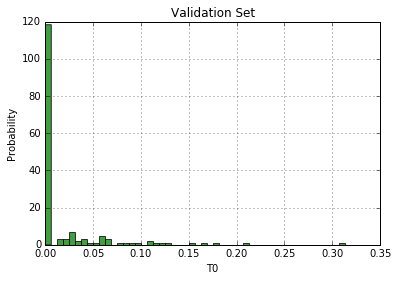

In [70]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

# the histogram of the data
n, bins, patches = plt.hist(test_data_features_val[T0_labels,column_inx], 50, normed=1, facecolor='green', alpha=0.75)

plt.xlabel('T0')
plt.ylabel('Probability')
plt.title('Validation Set')
#plt.axis([40, 160, 0, 0.03])
plt.grid(True)

plt.show()

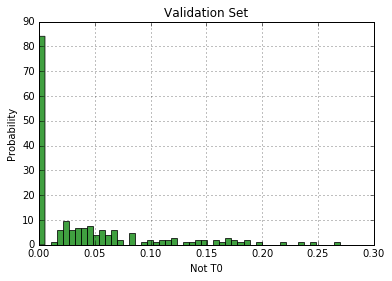

In [71]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

# the histogram of the data
n, bins, patches = plt.hist(test_data_features_val[notT0_labels,column_inx], 50, normed=1, facecolor='green', alpha=0.75)

plt.xlabel('Not T0')
plt.ylabel('Probability')
plt.title('Validation Set')
#plt.axis([40, 160, 0, 0.03])
plt.grid(True)

plt.show()

In [72]:
T0_labels = np.where(test1['boolean_label'] == 1)[0]
notT0_labels = np.where(test1['boolean_label'] != 1)[0]

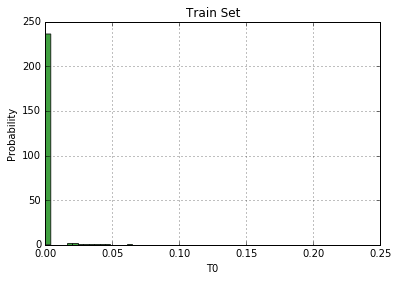

In [73]:
# the histogram of the data
n, bins, patches = plt.hist(test_data_features[T0_labels,column_inx], 50, normed=1, facecolor='green', alpha=0.75)

plt.xlabel('T0')
plt.ylabel('Probability')
plt.title('Train Set')
#plt.axis([40, 160, 0, 0.03])
plt.grid(True)

plt.show()

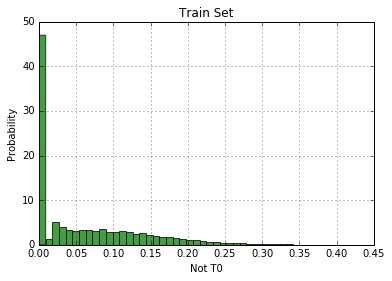

In [74]:
# the histogram of the data
n, bins, patches = plt.hist(test_data_features[notT0_labels,column_inx], 50, normed=1, facecolor='green', alpha=0.75)

plt.xlabel('Not T0')
plt.ylabel('Probability')
plt.title('Train Set')
#plt.axis([40, 160, 0, 0.03])
plt.grid(True)

plt.show()

### Now create VIP graphs

In [42]:
getplots(0, 'T0')
getplots(1, 'T1T2')
getplots(2, 'T3T4')

5000
5000
51
51
51
5000
5000
47
47
47
5000
5000
34
34
34


In [41]:
def getplots(pos, lab):
    # Take a look at the words in the vocabulary-- repeat for each position in feats
    vocab = vectorizer.get_feature_names()
    print len(vocab)
    print len(feats[pos])
    inxs = np.where(feats[pos] > 0.004)
    print len(inxs[0])
    features = feats[pos][inxs]
    print len(features)
    voc = [vocab[i] for (x,i) in np.ndenumerate(inxs)]
    print len(voc)

    plt.figure(figsize=(6 * 1.618, 6))
    index = np.arange(len(voc))
    bar_width = 0.35
    plt.bar(index, features, color = 'black', alpha=0.5)
    plt.xlabel('features')
    plt.ylabel('importance')
    plt.title('Feature importances ' + lab)
    plt.xticks(index + bar_width, voc)
    locs, labels = plt.xticks()
    plt.setp(labels, rotation = 90)
    plt.tight_layout()
    #plt.show()
    plt.savefig('/mnt/mypartition/pubmed_nlp_research/C_article_replication_and_translational_classification/try2-noMesh/vips' + lab + 'noMeshOrStops.png')

In [11]:
import re
import nltk

import pandas as pd
import numpy as np

from bs4 import BeautifulSoup
from nltk.corpus import stopwords

from nltk import PorterStemmer

class KaggleWord2VecUtility(object):
    """KaggleWord2VecUtility is a utility class for processing raw HTML text into segments for further learning"""

    @staticmethod
    def review_to_wordlist( review, remove_stopwords=False ):
        # Function to convert a document to a sequence of words,
        # optionally removing stop words.  Returns a list of words.
        #
        # 1. Remove HTML
        review_text = BeautifulSoup(review).get_text()
        #
        # 2. Remove non-letters
        review_text = re.sub("[^a-zA-Z]"," ", review_text)
        #
        # 3. Convert words to lower case and split them
        words = review_text.lower().split()
        #
        # 4. Optionally remove stop words (false by default)
        if remove_stopwords:
            stops = set(stopwords.words("english"))
            words = [w for w in words if not w in stops]
        #
        # 5. Return a list of words
        return(words)
    
    @staticmethod
    def review_to_words( review, remove_stopwords=False, stemmer=False):
        # Function to convert a raw review to a string of words
        # The input is a single string (a raw movie review), and 
        # the output is a single string (a preprocessed movie review)
        #
        # 1. Remove HTML
        review_text = BeautifulSoup(review).get_text() 
        #
        # 2. Remove non-letters        
        review_text = re.sub("[^a-zA-Z]", " ", review_text) 
        #
        # 3. Convert to lower case, split into individual words
        words = review_text.lower().split()                             
        #
        # 4. Optionally remove stop words (false by default)
        if remove_stopwords:
            stops = set(stopwords.words("english"))
            words = [w for w in words if not w in stops]  
            
        if stemmer:
            words = [PorterStemmer().stem_word(w) for w in words]
        #
        # 6. Join the words back into one string separated by space, 
        # and return the result.
        return( " ".join( words ))   

    # Define a function to split a review into parsed sentences
    @staticmethod
    def review_to_sentences( review, tokenizer, remove_stopwords=False ):
        # Function to split a review into parsed sentences. Returns a
        # list of sentences, where each sentence is a list of words
        #
        # 1. Use the NLTK tokenizer to split the paragraph into sentences
        raw_sentences = tokenizer.tokenize(review.decode('utf8').strip())
        #
        # 2. Loop over each sentence
        sentences = []
        for raw_sentence in raw_sentences:
            # If a sentence is empty, skip it
            if len(raw_sentence) > 0:
                # Otherwise, call review_to_wordlist to get a list of words
                sentences.append( KaggleWord2VecUtility.review_to_wordlist( raw_sentence, \
                  remove_stopwords ))
        #
        # Return the list of sentences (each sentence is a list of words,
        # so this returns a list of lists
        return sentences